To scale the individual compound profiles for a given sample $k$ and wavelength $j$, multiply the elution profile by the corresponding concentration loading ($kth$ row of $A$) and a spectral loading ($j$th row of $C$), as below:

In [255]:
%load_ext autoreload
%autoreload 2

from tensorly.decomposition import parafac2 as tl_parafac2
import numpy as np
import matplotlib.pyplot as plt
from pca_analysis.get_sample_data import get_zhang_data
import xarray as xr

raw_data: xr.DataArray = get_zhang_data()
ds = xr.Dataset(data_vars={"input_data": raw_data})
ds


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<xarray.Dataset> Size: 2MB
Dimensions:     (sample: 44, time: 31, mz: 200)
Coordinates:
  * sample      (sample) <U8 1kB 'ARG-BNS1' 'ARG-DDA1' ... 'SOU-SPI1' 'SOU-SRE1'
  * time        (time) float64 248B 16.44 16.46 16.47 ... 16.79 16.81 16.82
  * mz          (mz) float64 2kB 5.0 6.0 7.0 8.0 9.0 ... 201.0 202.0 203.0 204.0
Data variables:
    input_data  (sample, time, mz) float64 2MB 0.001538 0.0 0.0 ... 0.0 0.0 0.0

In [256]:
_decomp, err = tl_parafac2(
    tensor_slices=raw_data.to_numpy(),
    rank=3,
    return_errors=True,
    verbose=True,
    n_iter_max=500,
    nn_modes="all",
    linesearch=False,
)


/Users/jonathan/Library/Caches/pypoetry/virtualenvs/pca-analysis-6KQS4gUX-py3.12/lib/python3.12/site-packages/tensorly/decomposition/_parafac2.py:496: UserWarning: Mode `1` of PARAFAC2 fitted with ALS cannot be constrained to be truly non-negative. See the documentation for more info.
  warn(


Starting iteration 0
reconstruction error=0.37049494817820733
iteration 1, reconstruction error: 0.295985167127927, decrease = 0.07450978105028033
iteration 2, reconstruction error: 0.2763779041350225, decrease = 0.019607262992904495
iteration 3, reconstruction error: 0.27329709695204346, decrease = 0.0030808071829790395
iteration 4, reconstruction error: 0.2726659654809415, decrease = 0.0006311314711019422
PARAFAC2 reconstruction error=0.2756997851442818
Starting iteration 1
reconstruction error=0.10811740500460383
iteration 1, reconstruction error: 0.10717948552678656, decrease = 0.0009379194778172673
iteration 2, reconstruction error: 0.10701047776721982, decrease = 0.00016900775956674163
iteration 3, reconstruction error: 0.10693227104581671, decrease = 7.820672140311513e-05
iteration 4, reconstruction error: 0.10689442118323227, decrease = 3.7849862584440896e-05
PARAFAC2 reconstruction error=0.11050678287787852, variation=0.16519300226640327.
Starting iteration 2
reconstruction er

In [257]:
# create an xarray dataset data structure for the parafac2 results..
# got A, B, C and projections. We dont care abotu the pure B or the projections so
# combine them into Bs.
# for a tensor ijk A is ir, Bs is ijr and c is kr.
# can get the coordinates from the raw data for ijk, r comes from the rank inputted.

from tensorly.parafac2_tensor import apply_parafac2_projections
import numpy as np
import xarray as xr


In [258]:
from tensorly.parafac2_tensor import Parafac2Tensor


def decomp_as_xr(
    input_data: xr.DataArray,
    rank: int,
    decomp: Parafac2Tensor,
    coord1_label: str,
    coord2_label: str,
    coord3_label: str,
):
    """
    Taking a Parafac2Tensor, convert it to a xr.Dataset using the input xr.
    DataArray. Requires the model rank and coordinate labels.

    Obviously this is not useful the input data was not an xr.DataArray.
    """
    applied_projections = apply_parafac2_projections(decomp)
    A = applied_projections[1][0]
    B = np.stack(applied_projections[1][1])
    C = applied_projections[1][2]

    dim1_coords = input_data.coords[coord1_label]
    dim2_coords = input_data.coords[coord2_label]
    rank = [x + 1 for x in range(3)]
    dim3_coords = input_data.coords[coord3_label]

    xr_A = xr.DataArray(data=A, coords={coord1_label: dim1_coords, "component": rank})
    xr_B = xr.DataArray(
        data=B,
        coords={
            coord1_label: dim1_coords,
            coord2_label: dim2_coords,
            "component": rank,
        },
    )
    xr_C = xr.DataArray(data=C, coords={coord3_label: dim3_coords, "component": rank})

    parafac2_ds = xr.Dataset(data_vars={"A": xr_A, "Bs": xr_B, "C": xr_C})
    return parafac2_ds


parafac2_ds = decomp_as_xr(
    input_data=raw_data,
    rank=3,
    decomp=_decomp,
    coord1_label="sample",
    coord2_label="time",
    coord3_label="mz",
)

ds = xr.merge([ds, parafac2_ds])
ds


<xarray.Dataset> Size: 2MB
Dimensions:     (sample: 44, time: 31, mz: 200, component: 3)
Coordinates:
  * sample      (sample) <U8 1kB 'ARG-BNS1' 'ARG-DDA1' ... 'SOU-SPI1' 'SOU-SRE1'
  * time        (time) float64 248B 16.44 16.46 16.47 ... 16.79 16.81 16.82
  * mz          (mz) float64 2kB 5.0 6.0 7.0 8.0 9.0 ... 201.0 202.0 203.0 204.0
  * component   (component) int64 24B 1 2 3
Data variables:
    input_data  (sample, time, mz) float64 2MB 0.001538 0.0 0.0 ... 0.0 0.0 0.0
    A           (sample, component) float64 1kB 0.0001537 9.631e-05 ... 0.000967
    Bs          (sample, time, component) float64 33kB 0.001609 ... 0.2157
    C           (mz, component) float64 5kB 0.8939 0.2608 7.17 ... 0.0 0.0 0.0

In [259]:
def comp_slices_to_xr(input_data) -> xr.DataArray:
    # now compute the componant slices. From memory it is computed as the outer product of the three tensors?

    comp_slices = np.einsum(
        "ir, ijr, kr ->irjk",
        input_data.A.values,
        input_data.Bs.values,
        input_data.C.values,
    )

    coords = {dim: input_data.coords[dim].values for dim in parafac2_ds.dims}
    comp_slice_xr = xr.DataArray(data=comp_slices, coords=coords)

    return comp_slice_xr


ds = ds.assign(components=comp_slices_to_xr(parafac2_ds))
ds


<xarray.Dataset> Size: 9MB
Dimensions:     (sample: 44, time: 31, mz: 200, component: 3)
Coordinates:
  * sample      (sample) <U8 1kB 'ARG-BNS1' 'ARG-DDA1' ... 'SOU-SPI1' 'SOU-SRE1'
  * time        (time) float64 248B 16.44 16.46 16.47 ... 16.79 16.81 16.82
  * mz          (mz) float64 2kB 5.0 6.0 7.0 8.0 9.0 ... 201.0 202.0 203.0 204.0
  * component   (component) int64 24B 1 2 3
Data variables:
    input_data  (sample, time, mz) float64 2MB 0.001538 0.0 0.0 ... 0.0 0.0 0.0
    A           (sample, component) float64 1kB 0.0001537 9.631e-05 ... 0.000967
    Bs          (sample, time, component) float64 33kB 0.001609 ... 0.2157
    C           (mz, component) float64 5kB 0.8939 0.2608 7.17 ... 0.0 0.0 0.0
    components  (sample, component, time, mz) float64 7MB 2.21e-07 0.0 ... 0.0

# Individual Factors

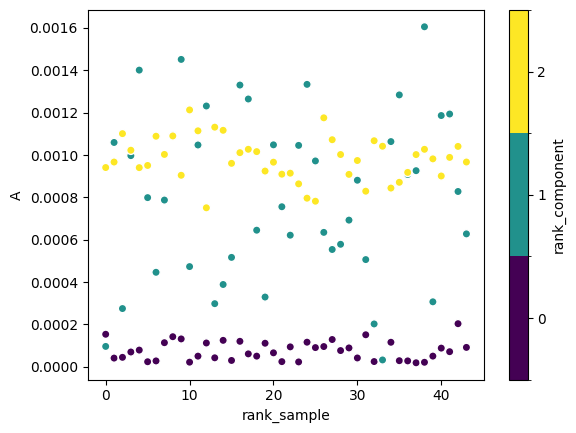

In [260]:
## A

ds = ds.assign_coords(
    {
        "rank_sample": (
            "sample",
            [x for x in range(len(parafac2_ds.A.coords["sample"]))],
        ),
        "rank_component": (
            "component",
            [str(x) for x in range(len(parafac2_ds.A.coords["component"]))],
        ),
    }
)

ds.A.plot.scatter(x="rank_sample", hue="rank_component")


As shown in the viz above, along all the samples (rank_sample), component 0 has the highest weighting, followed by 1 and 0. Presumably 2 is the noise component.

## Bs


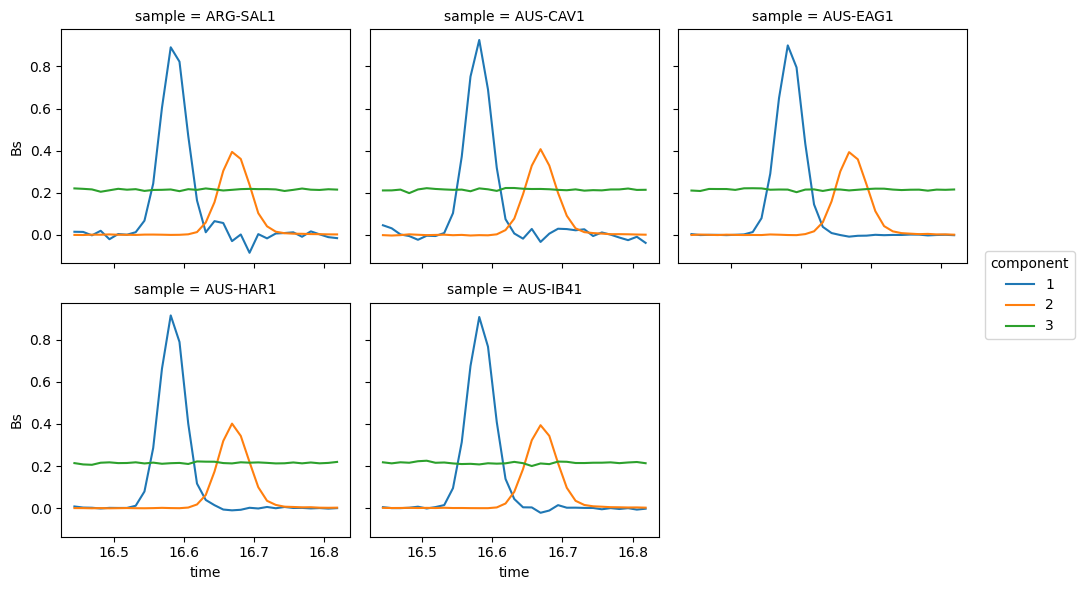

In [261]:
ds.isel(sample=slice(5, 10)).Bs.plot.line(x="time", col="sample", col_wrap=3)


This is the elution profile of each sample prior to scaling, i.e. the pure profile. As we can see, component 2 corresponds to the background noise, while 1 and 3 represent the peaks.

## C

Text(0.5, 1.0, 'The Spectral Profile')

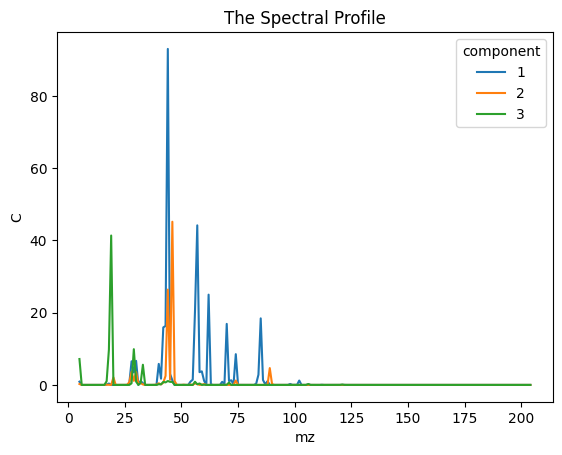

In [262]:
ds.C.plot.line(x="mz")
plt.title("The Spectral Profile")


The viz above is the pure spectral profile of the dataset. Note the extremely large maxima between 20 and 25 for the component corresponding to the noise, and how between 40 and 50 how an optimal S/N is reached, particularly for component 3.

# Reconstruction

The reconstruction is the recombination of the PARAFAC2 model into a 3 mode tensor. As I have already prepared the component slices, the simplest would be to sum them.

In [263]:
recon_data = np.einsum("irjk->ijk", ds.components)
recon_xr = xr.DataArray(data=recon_data, dims=raw_data.dims, coords=raw_data.coords)
ds = ds.assign(recon=recon_xr)
ds


<xarray.Dataset> Size: 11MB
Dimensions:         (sample: 44, time: 31, mz: 200, component: 3)
Coordinates:
  * sample          (sample) <U8 1kB 'ARG-BNS1' 'ARG-DDA1' ... 'SOU-SRE1'
  * time            (time) float64 248B 16.44 16.46 16.47 ... 16.79 16.81 16.82
  * mz              (mz) float64 2kB 5.0 6.0 7.0 8.0 ... 201.0 202.0 203.0 204.0
  * component       (component) int64 24B 1 2 3
    rank_sample     (sample) int64 352B 0 1 2 3 4 5 6 7 ... 37 38 39 40 41 42 43
    rank_component  (component) <U1 12B '0' '1' '2'
Data variables:
    input_data      (sample, time, mz) float64 2MB 0.001538 0.0 0.0 ... 0.0 0.0
    A               (sample, component) float64 1kB 0.0001537 ... 0.000967
    Bs              (sample, time, component) float64 33kB 0.001609 ... 0.2157
    C               (mz, component) float64 5kB 0.8939 0.2608 7.17 ... 0.0 0.0
    components      (sample, component, time, mz) float64 7MB 2.21e-07 ... 0.0
    recon           (sample, time, mz) float64 2MB 0.001451 0.0 0.0 ... 0.0 0.0

Text(0.5, 1.0, 'Input Data and Components per Sample')

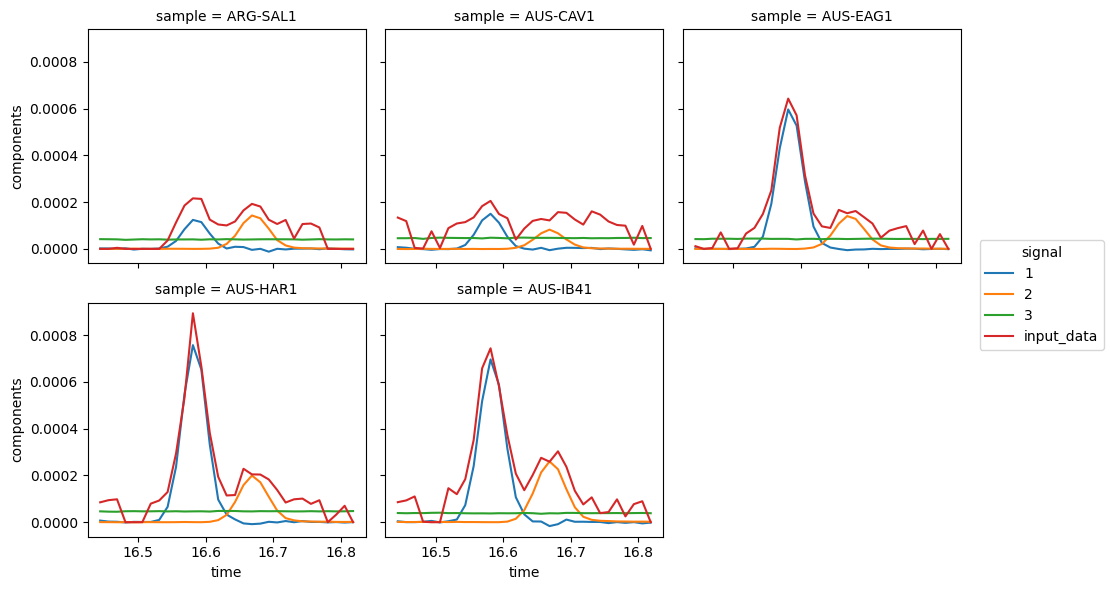

In [ ]:
# while we earlier treated the components as a variable with a component dim,
# we now want to treat it component dim as a subset of a dim 'signal' of which
# input_data and recon would fall into as well. This is actually more correct
# as their units are the same - AU (?)
# doing this from the xarray dataset is not straight forward.A

# first make the "component" dim categorical by casting it to str and naming it "signal" then concat the input data and components vars, dropping differing coords.

ds_ = ds.rename({"component": "signal"})
components_ = (
    ds_.components.assign_coords(component=ds_.components.coords["signal"].astype(str))
    .drop_vars("rank_component")
    .drop_vars("component")
)
input_data_ = ds_.input_data.expand_dims(dim={"signal": ["input_data"]}).transpose(
    "sample", "signal", "time", "mz"
)

# secondly select the subset to plot and viz.
xr.concat(
    dim="signal",
    objs=[
        components_,
        input_data_,
    ],
).isel(mz=35, sample=slice(5, 10)).plot.line(
    x="time", col="sample", hue="signal", col_wrap=3
)

plt.title("Input Data and Components per Sample")


As we can see in the above viz, the decomposition looks sound, and fruthermore the visualisation is very informative, containing information about the pure analytes and noise compared to the convoluted signal.


# Conclusion

Using the Zhang et al. GC-MS peak data, observation of the following features was made: The scaled elution profiles, the pure elution profiles, A as a function of K for each component and C as a function of J. A reconstruction routine was developed and visualisations the results of reconstruction. The reconstruction routine/viz should be integrated into a pipeline.